In [71]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

plt.style.use('ggplot')

pd.options.display.max_columns = None


## Preparating the data sets

In [72]:
# Training data sets
train_beneficiarydata = pd.read_csv("./healthCareData/train_beneficiarydata.csv")
train_inpatientdata = pd.read_csv("./healthCareData/train_inpatientdata.csv")
train_outpatientdata = pd.read_csv("./healthCareData/train_outpatientdata.csv")
train_potentialfraud = pd.read_csv("./healthCareData/train_potentialfraud.csv")

#Testing data sets
test_beneficiarydata = pd.read_csv("./healthCareData/test_beneficiarydata.csv")
test_inpatientdata = pd.read_csv("./healthCareData/test_inpatientdata.csv")
test_outpatientdata = pd.read_csv("./healthCareData/test_outpatientdata.csv")
test_potentialfraud = pd.read_csv("./healthCareData/test_potentialfraud.csv")


In [73]:
#Create columns for inpatient and outpatient data.
train_inpatientdata['patientType'] = np.repeat('inpatient', len(train_inpatientdata))
train_outpatientdata['patientType'] = np.repeat('outpatient', len(train_outpatientdata))

train_inpatientdata['patientType'] = np.repeat('inpatient', len(train_inpatientdata))
train_outpatientdata['patientType'] = np.repeat('outpatient', len(train_outpatientdata))

#Combining the inpatient and outpatient data
patient = pd.concat([train_inpatientdata, train_outpatientdata], axis=0)



In [74]:
#Merge the patient data frame and 
full_data =pd.merge(patient, train_beneficiarydata, on='BeneID', how='left')

In [76]:
full_data= pd.merge(full_data, train_potentialfraud, on='Provider', how='left')

## Up-Sampling the Minority Class

 One technique to train an imbalanced classification model is to fabricate synthesized minority class data, knowning as
**up-sampling**. Up-sampling bootstraps only the minority class samples to make the major:minor ratio more balanced


In [78]:
#Load the data with combone features
train_data = pd.read_pickle("train_dataset.pkl")



In [79]:
train_data.drop(['WeeklyClaims', 'MonthlyClaims', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'DeductibleAmtPaid',
                'InscClaimAmtReimbursed'], axis=1, inplace=True)

In [80]:
opPhy = full_data.groupby(['Provider', 'OperatingPhysician'])['OperatingPhysician'].count().reset_index(name='a').\
groupby('Provider')['a'].count().reset_index(name= 'NumDistincOpPhy')


In [81]:
train_data2 = pd.merge(train_data, opPhy, on='Provider', how='left')

In [82]:
train_data2['NumDistincOpPhy'] = train_data2['NumDistincOpPhy'].fillna(0)

In [83]:
otherPhy = full_data.groupby(['Provider', 'OtherPhysician'])['OtherPhysician'].count().reset_index(name='a').\
groupby('Provider')['a'].count().reset_index(name= 'NumDistincOtherPhy')


In [84]:
train_data3 = pd.merge(train_data2, otherPhy, on='Provider', how='left')

In [85]:
train_data3['NumDistincOtherPhy'] = train_data3['NumDistincOtherPhy'].fillna(0)

In [86]:
train_data3['PotentialFraud'] = train_data3['PotentialFraud'].apply(lambda x : 1 if x=='Yes' else 0)

In [87]:
# Check the numbers for the response variable
train_data3['PotentialFraud'].value_counts()

0    4904
1     506
Name: PotentialFraud, dtype: int64

In [88]:
minorIndex = train_data3[train_data3['PotentialFraud']==1].Provider.values

resampled = resample(minorIndex, n_samples=4904-506)
LEFT = pd.DataFrame(list(train_data3.Provider) + list(resampled), columns=['INDEX'])

train_data = pd.merge(LEFT, train_data3, how='left', left_on ='INDEX', right_on='Provider')


In [89]:
train_data['PotentialFraud'].value_counts()

1    4904
0    4904
Name: PotentialFraud, dtype: int64

## dummify the service type variable. This data set will be used for the Linear models and SVM

In [90]:
# Dummify the ServiceType
dummy = pd.get_dummies(train_data['ServiceType'], drop_first=True)

train_data2= pd.concat([train_data, dummy], axis=1).drop('ServiceType', axis=1)


## Scale the features and split the data

In [91]:
#Scale the features
X= train_data2.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
scaled_X = scale(X)
Y= train_data2['PotentialFraud']


In [92]:
np.random.seed(4)
# Split the data into training and testing data

X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=42, stratify=Y)


## Stochastic Gradient Descent Classifier

In [134]:
sgd = SGDClassifier()

sgd.set_params(max_iter=2000, loss='log')

np.random.seed(4)
grid_param = [{
    "alpha": np.logspace(-3,-1, 10),
    "penalty" : ['l1', 'l2'],
    "max_iter":[7000, 8000, 9000]
     }]

sgd_search = GridSearchCV(estimator=sgd, param_grid=grid_param, scoring='accuracy', cv=5, return_train_score=True)
sgd_search = sgd_search.fit(X_train, y_train)

In [135]:
print(sgd_search.best_params_)
print(sgd_search.best_score_)

{'alpha': 0.007742636826811269, 'max_iter': 9000, 'penalty': 'l2'}
0.8646447694787138


In [136]:
sgd_pred =sgd_search.best_estimator_.predict(X_test)

confusion_matrix(y_test, sgd_pred)
(840+853)/(840+141+128+853)

0.8628950050968399

## Penalized Logistic Regression

In [57]:
logit=LogisticRegression(solver='liblinear', penalty='l1')

grid_param = [{
    "C": np.logspace(-1, 1, 10)
   }]

In [58]:
np.random.seed(5)

logit_search= GridSearchCV(logit, param_grid=grid_param, scoring='accuracy', cv=5,
                          n_jobs=-1, return_train_score=True)
logit_search= logit_search.fit(X_train, y_train)

In [59]:
print(logit_search.best_params_)
print(logit_search.best_score_)

{'C': 0.774263682681127}
0.8719097319482163


In [63]:
logit_pred =logit_search.best_estimator_.predict(X_test)

confusion_matrix(y_test, logit_pred)
(840+861)/(840+141+120+861)

0.8669724770642202

## Suport Vector Machine

In [24]:
svm= svm.SVC()

grid_para_svm = [
    {'C': range(4000, 4500, 100),
     'kernel': ['poly'],
     'degree': [3, 4, 5]},
    {'C': range(4000, 4500, 100),
     'gamma': np.logspace(-2, -4, 5),
     'kernel': ['rbf']}
]


In [25]:
np.random.seed(5)
svm_search = GridSearchCV(svm, grid_para_svm, scoring='accuracy', cv=5, iid=True, return_train_score=True, n_jobs=-1)
svm_search.fit(X_train, y_train)

C:\Users\randy\anaconda\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=-1,
             param_grid=[{'C': range(4000, 4500, 100), 'degree': [3, 4, 5],
                          'kernel': ['poly']},
                         {'C': range(4000, 4500, 100),
                          'gamma': array([0.01      , 0.00316228, 0.001     , 0.00031623, 0.0001    ]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [26]:
print(svm_search.best_params_)
print(svm_search.best_score_)

{'C': 4300, 'degree': 3, 'kernel': 'poly'}
0.9579403517716034


In [29]:
svm_pred = svm_search.best_estimator_.predict(X_test)
confusion_matrix(y_test, svm_pred)
(914+978)/(914+67+3+978)

0.9643221202854231

## Preparing the data for Random Forest and Gradient Boosting Classifier

In [21]:
le =LabelEncoder()
serviceType =le.fit_transform(train_data['ServiceType'])

train_nonlinear= train_data.copy()
train_nonlinear['ServiceType'] = serviceType

features = train_nonlinear.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
target= train_nonlinear['PotentialFraud']

np.random.seed(5)

X_trainN, X_testN, y_trainN, y_testN = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)



## Random Forest Classifier

In [34]:
randomForest= ensemble.RandomForestClassifier()

np.random.seed(5)

grid_param = ({
    'criterion': ['gini', 'entropy'],
    'max_depth': range(30, 36),
    'n_estimators': range(10, 111, 20),
     'min_samples_split': [2,3, 4],
    'min_samples_leaf':[ 2,3,4]
})

forest_search = GridSearchCV(randomForest, grid_param, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
forest_search = forest_search.fit(X_trainN, y_trainN)

In [35]:
print(forest_search.best_params_)
print(forest_search.best_score_)

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}
0.9737455395744785


In [37]:
forest_pred = forest_search.best_estimator_.predict(X_testN)
confusion_matrix(y_testN, forest_pred)
(937+981)/(937+44+0+981)

0.9775739041794088

Text(0.5, 1.0, 'Feature Importance Random Forest Classifier')

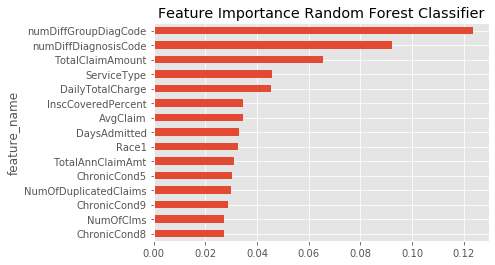

In [38]:
#Feature importance
sorted_importance = sorted(zip(features.columns, forest_search.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)[:15]
sorted_importance.sort(key= lambda t : t[1])

a, b = zip(*sorted_importance) # this splits the list of tuples into two lists

pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.barh(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Random Forest Classifier')


## Gradient Boosting Classifier

In [112]:
# gbc= ensemble.GradientBoostingClassifier()

# np.random.seed(5)
# grid_boost_para = [{
#     "n_estimators": [1500, 2000, 2500],
#    "learning_rate":np.linspace(0.1, 1, 10),
#     "min_samples_split": range(1, 10),
#     "min_samples_leaf":range(1,10),
#     "max_features": list(range(1, X_trainN.shape[1])),
#     "max_depth": range(5, 30, 5)
# }]

# grid_boost = GridSearchCV(gbc, grid_boost_para, scoring ='accuracy',cv=5, n_jobs=-1)
# grid_boost.fit(X_trainN, y_trainN)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [113]:
print(grid_boost.best_params_)
print(grid_boost.best_score_)


{'learning_rate': 0.56, 'max_depth': 25, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 1500}
0.9794802158054342


In [116]:
boost_pred = grid_boost.best_estimator_.predict(X_testN)
confusion_matrix(y_testN, boost_pred)
(950+977)/(950+31+4+977)



0.9821610601427115

In [119]:
# #Feature importance
# sorted_importance = sorted(zip(features.columns, grid_boost.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)[:15]
# sorted_importance.sort(key= lambda t : t[1])

# a, b = zip(*sorted_importance) # this splits the list of tuples into two lists

# pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.barh(x='feature_name',y='importance_score', legend=None)
# plt.title('Feature Importance Gradient Boosting Classifier')


## XGBoost Classifier

In [22]:
forest_im = ensemble.RandomForestClassifier(class_weight='balanced')
le =LabelEncoder()
serviceType =le.fit_transform(train_data3['ServiceType'])


train_im= train_data3.copy()
train_im['ServiceType'] = serviceType

features_im = train_im.drop(['Provider', 'PotentialFraud'], axis=1)
target_im = train_im['PotentialFraud']



In [23]:
np.random.seed(5)

X_trainM, X_testM, y_trainM, y_testM = train_test_split(features_im, target_im, test_size=0.2, random_state=42, stratify=target_im)


In [121]:
xgb= XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
weights=[1200, 1210, 1230, 1250, 1300]
param_grid = dict(scale_pos_weight=weights)


# define grid search
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='recall',  return_train_score=True)

# execute the grid search

grid_result = grid.fit(X_trainM, y_trainM)


In [124]:
print(grid_result.best_params_)
grid_result.best_score_

{'scale_pos_weight': 1230}


0.688109756097561

In [125]:
grid_pred= grid_result.best_estimator_.predict(X_testM)
recall_score(y_testM, grid_pred)

0.7623762376237624

In [120]:
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)>

## Random Forest with imabalance data

In [127]:
forest_im = ensemble.RandomForestClassifier(class_weight='balanced')
le =LabelEncoder()
serviceType =le.fit_transform(train_data3['ServiceType'])


train_im= train_data3.copy()
train_im['ServiceType'] = serviceType

features_im = train_im.drop(['Provider', 'PotentialFraud'], axis=1)
target_im = train_im['PotentialFraud']



In [128]:
np.random.seed(6)
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

im_search = GridSearchCV(forest_im, grid_param, scoring='recall', cv=5, n_jobs=-1)
im_search = im_search.fit(X_trainM, y_trainM)

In [130]:
print(im_search.best_params_)
print(im_search.best_score_)

{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 20}
0.874074074074074


In [131]:
im_pred = im_search.best_estimator_.predict(X_testM)
recall_score(y_testM, im_pred)

0.8613861386138614

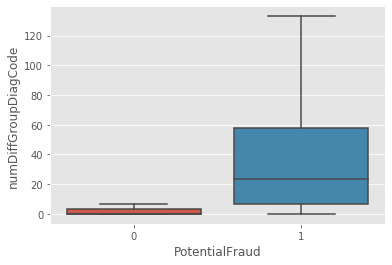

In [27]:
sns.boxplot(x='PotentialFraud', y='numDiffGroupDiagCode', data=train_data3, showfliers=False)

## Unary classification vs Random Forest and Gradient Boosting most important features.


In [34]:
forest_trial= ensemble.RandomForestClassifier(criterion='gini', max_depth=29, n_estimators=10)
le = LabelEncoder()

serviceType =le.fit_transform(train_data['ServiceType'])
train= train_data.copy()
train['ServiceType'] = serviceType

features = train.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
target= train['PotentialFraud']




In [70]:
acc= {}

for i in range(len(features.columns)):
    forest_trial.fit(pd.DataFrame(features.iloc[:,i]), target)
    acc[features.columns[i]] = forest_trial.score(pd.DataFrame(features.iloc[:,i]), target)


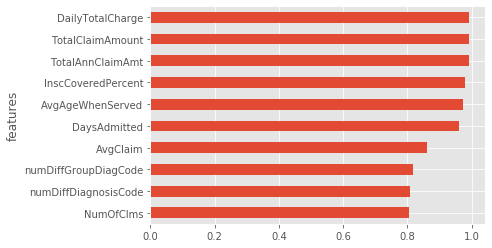

In [69]:
a = sorted(acc.items(), key= lambda x : x[1],reverse=True)[:10]
a.sort(key = lambda x : x[1])

c, d  = zip(*a)

pd.DataFrame({'features':c, 'accuracy': d}).plot(kind='barh', x='features', y='accuracy', legend=False)

## Why does the gradient boosting and random forest model chose ' NumOfGroupDiagCOde" as the most important features?

- Diagnosis related group code(DRG)  are a means of classifying a patient under a particular group where those assigned are likely to need a similar level of hospital resources for their care.

- Each DRG has a payment weight assigned to it, allowing the hospital to determine how much it can charge for its services.

- For example, if when performing an appendectomy, a physician simply records the diagnosis as “appendicitis,” the lowest or neutral DRG category will be applied. Recording the condition as “acute appendicitis,” means that the CC category will be applied. An abscess or peritonitis falls under the MCC category, the highest level of DRG assignment.

- So how does it relates to the problem earlier, the claim amoun will depend on te type of code used.

- And what does it mean for fraudulent activities?


- It could happen in the physicians level where he diagnose worse condition than it should be
- Or someone who is incharge of coding the diagnosis intentionally or unintentionally upcode the diagnosis.

- Upcoding individual patients to appear sickier therefore more costly to treat than they actually are.

